# DS-SF-27 | Lab 08 | k-Nearest Neighbors | Answer Key

In [1]:
import os

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import preprocessing, neighbors, grid_search, cross_validation

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'boston.csv'))

In [3]:
df

,CRIM,ZN,INDUS,CHAS,NOX,...,TAX,PTRATIO,BLACK,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,...,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,...,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,...,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,...,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,...,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,...,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,...,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,...,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,...,273,21.0,393.45,6.48,22.0


The Boston dataset concerns itself with housing values in suburbs of Boston.  A description of the dataset is as follows:

- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sqft
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River binary/dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centers
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate (per ten thousands of dollars)
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: % lower status of the population
- MEDV: Median value of owner-occupied homes (in thousands of dollars)

> ## Question 1.  Let's first categorize `MEDV` to 4 groups: Bottom 20% as Level 1, next 30% as Level 2, next 30% categorized as Level 3, and the top 20% as Level 4.  Please create a new variable `MEDV_Category` that stores the level number

In [4]:
level_2 = ((df.MEDV > df.MEDV.quantile(.2)) & (df.MEDV <= df.MEDV.quantile(.5)))
level_3 = ((df.MEDV > df.MEDV.quantile(.5)) & (df.MEDV <= df.MEDV.quantile(.8)))
level_4 = (df.MEDV > df.MEDV.quantile(.8))

df['MEDV_Category'] = '1'
df.loc[level_2, 'MEDV_Category'] = '2'
df.loc[level_3, 'MEDV_Category'] = '3'
df.loc[level_4, 'MEDV_Category'] = '4'

## Our goal is to predict `MEDV_Category` based on `RM`, `PTRATIO`, and `LSTAT`

> ## Question 2.  First normalize `RM`, `PTRATIO`, and `LSTAT`.  By normalizing, we mean to scale each variable between 0 and 1 with the lowest value as 0 and the highest value as 1

In [5]:
df

,CRIM,ZN,INDUS,CHAS,NOX,...,PTRATIO,BLACK,LSTAT,MEDV,MEDV_Category
0,0.00632,18.0,2.31,0,0.538,...,15.3,396.90,4.98,24.0,3
1,0.02731,0.0,7.07,0,0.469,...,17.8,396.90,9.14,21.6,3
2,0.02729,0.0,7.07,0,0.469,...,17.8,392.83,4.03,34.7,4
3,0.03237,0.0,2.18,0,0.458,...,18.7,394.63,2.94,33.4,4
4,0.06905,0.0,2.18,0,0.458,...,18.7,396.90,5.33,36.2,4
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,...,21.0,391.99,9.67,22.4,3
502,0.04527,0.0,11.93,0,0.573,...,21.0,396.90,9.08,20.6,2
503,0.06076,0.0,11.93,0,0.573,...,21.0,396.90,5.64,23.9,3
504,0.10959,0.0,11.93,0,0.573,...,21.0,393.45,6.48,22.0,3


In [6]:
X = df[ ['RM', 'PTRATIO', 'LSTAT'] ]

scaler = preprocessing.MinMaxScaler().fit(X)

X = scaler.transform(X)

In [7]:
X

array([[ 0.57750527,  0.28723404,  0.08967991],
       [ 0.5479977 ,  0.55319149,  0.2044702 ],
       [ 0.6943859 ,  0.55319149,  0.06346578],
       ..., 
       [ 0.65433991,  0.89361702,  0.10789183],
       [ 0.61946733,  0.89361702,  0.13107064],
       [ 0.47307913,  0.89361702,  0.16970199]])

> ## Question 3.  Run a KNN classifier with 5 nearest neighbors and report your misclassification error; set weights to uniform

In [8]:
c = df.MEDV_Category

model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'uniform').fit(X, c)

accuracy = model.score(X, c)
misclassification_error = 1 - accuracy

misclassification_error

0.2134387351778656

Answer: ~0.21

> ## Question 4.  Is this error reliable?

Answer: No, this is a training error and can be skewed due to overfitting.  This is not a validation or cross-validation error.

> ## Question 5.  Now use 10-fold cross-validation to choose the most efficient `k`

In [9]:
k_cv = 10 # 10-fold CV
k_nn = range(1, df.shape[0] * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn},
    cv = cross_validation.KFold(df.shape[0], n_folds = k_cv)
)

gs.fit(X, c)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'score': [score.mean_validation_score for score in gs.grid_scores_]})

score_df

,k,score
0,1,0.608696
1,2,0.650198
2,3,0.666008
3,4,0.671937
4,5,0.658103
...,...,...
449,450,0.166008
450,451,0.166008
451,452,0.166008
452,453,0.166008


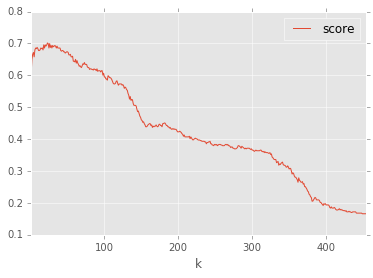

In [10]:
score_df.plot(x = 'k', y = 'score')

> ## Question 6.  Explain your findings

In [11]:
score_df[score_df.score == score_df.score.max()]

,k,score
22,23,0.701581


Answer: It seems like `k = 22` produces the best result with an accuracy close to 70%. This accuracy is less than what we found before but way more reliable.

> ## Question 7.  Train your model with the optimal `k` you found above (don't worry if it changes from time to time - if that is the case use the one that is usually the best)

In [12]:
model = neighbors.KNeighborsClassifier(n_neighbors = 22, weights = 'uniform').fit(X, c)

accuracy = model.score(X, c)
misclassification_error = 1 - accuracy

misclassification_error

0.25296442687747034

Answer: ~ 0.25

> ## Question 8.  After training your model with that `k`, use it to predict the class of a neighborhood with `RM = 2`, `PRATIO = 19`, and `LSTAT = 3.5`

In [13]:
predict_X = [ [2, 19, 3.5] ]
predict_X = scaler.transform(predict_X)

predict_y = model.predict(predict_X)
predict_y

array(['2'], dtype=object)

Answer: 2